In [20]:
suppressMessages(library("EnsDb.Hsapiens.v86"))
suppressMessages(library(scater))
suppressMessages(library(tidyverse))
library(beachmat)

In [21]:
source("../BSSI_scRNAseq//pipeline_class_07082020.R")

In [22]:
opt = list(in_dir = "/home/jgagnon1/jupyter-notebook-dir", gene_info_file = "MS_Nature_gene_info.csv", 
          meta_file = "MS_Nature_meta_data.csv", sampleID_var = "sample", cluster_var = "cell_type",
          cluster = "Astrocytes", group_var = "diagnosis", reference_group = "Control", alternative_group = "MS", 
          count_file = "MS_Nature_UMI_subset.mtx", covars = "Capbatch,age,sex", 
          out_dir =  "/home/jgagnon1/scRNAseq/", 
          out_prefix = "MS_Nature",glmm_model="nbinom2")

if (is.na(opt$covars)) {
  covars = NULL 
} else {
  covars = unlist(strsplit(opt$covars, split = "[ ,;]+"))
}

UMI_data<-readMM(file.path(opt$in_dir, opt$count_file))
meta_info=read.csv(file.path(opt$in_dir, opt$meta_file), stringsAsFactors=FALSE)
gene_info=read.csv(file.path(opt$in_dir, opt$gene_info_file), stringsAsFactors=FALSE)
meta_info<-meta_info%>%dplyr:::mutate(cell_type= case_when(cell_type=="OL-C"|cell_type=="OL-B"|cell_type=="OL-A"~"OL",
                                                           cell_type=="EN-L2-3-A"|cell_type=="EN-L2-3-B"~"EN-L2-3",
                                                           TRUE~cell_type))
meta_info$cell_type <- gsub(" ", "_", meta_info$cell_type)
meta_info<-meta_info%>%dplyr:::mutate(stage= case_when(stage=="Acute/Chronic active"~"Active",
                                                       stage=="Chronic inactive"~"Inactive",
                                                       TRUE~"Control"))
count_data <- t(UMI_data)
colnames(count_data)<-meta_info$cell
rownames(count_data) <- gene_info$index

# load the data
sce <- BiostatsSingleCell$new(count_data = count_data,
                              meta_data = meta_info,
                              sampleId_col = opt$sampleID_var,
                              cluster_col = opt$cluster_var,
                              treatment_col = opt$group_var)


Dimensions of counts data: 
[1] 33525 44992

Cluster summary...
      Astrocytes B_cells Endo_cells EN-L2-3 EN-L4 EN-L5-6 EN-MIX EN-PYR Glia-MIX IN-PVALB IN-SST IN-SV2C IN-VIP Microglia   OL  OPC Phagocytes Stromal_cells T_cells
                                                                                                                                                                    
C1           265       0          1     276   118     116    141      2       65       78     32      26    116        75  445  151         15             3       0
C2            37       0          0     179   134     113    259      2      120       53     58      22     90         1  114   63          2             0       0
C3           356       0          0     473   185     168    131      5       67      132     70      60    159         8  821  246          3             2       1
C4           291       0          0     556   301     179     60      6       23      108     73      44    201

In [23]:
# 1st round of filtering
sce$apply_filter(min.perc.cells.per.gene = 0.00) # 0% expression requirement

# set mode
sce$set_group_mode(cluster_of_interest = opt$cluster, ref_group = opt$reference_group, alt_group = opt$alternative_group)

# Filtering round 2
sce_qc <- sce$apply_filter_contrasts_R6()


Dimensions of scRNAseq counts data after filtering...
[1] 33525 44990

Cluster summary...
      Astrocytes B_cells Endo_cells EN-L2-3 EN-L4 EN-L5-6 EN-MIX EN-PYR Glia-MIX IN-PVALB IN-SST IN-SV2C IN-VIP Microglia   OL  OPC Phagocytes Stromal_cells T_cells
                                                                                                                                                                    
C1           265       0          1     276   118     116    141      2       65       78     32      26    116        75  445  151         15             3       0
C2            37       0          0     179   134     113    259      2      120       53     58      22     90         1  114   63          2             0       0
C3           356       0          0     473   185     168    131      5       67      132     70      60    159         8  821  246          3             2       1
C4           291       0          0     556   301     179     60      6       23     

Minimum cells per gene was set to 158


Summary after filtering...
Dimensions of counts data: 
[1]  652 5360

Cluster summary...
      Astrocytes
                
C1           265
C2            37
C3           356
C4           291
C5           301
C6           232
C7            21
C8            42
C9            26
MS1          387
MS10         231
MS11          42
MS12         613
MS2          450
MS3          166
MS4          370
MS5          315
MS6          335
MS7          222
MS8          156
MS9          502

Mitochondrial genes found: 
character(0)

Dimensions of pseudo-bulk counts data: 
[1] 652  21


In [24]:
cluster = opt$cluster
prefix = opt$out_prefix

Performed DE analysis for 652 genes.
Model failed to converge for 0 (0%) genes!


ID,log2FC,Pvalue,Error,Warning,AICvalue,BICvalue,FDR
FMN2,0.6924677,2.266782e-20,FALSE,NA,21092.12,21171.16,1.477942e-17
ZFHX4,-0.9454566,5.486738e-13,FALSE,NA,12883.21,12962.25,1.788677e-10
AC092691.1,-0.8018771,2.090069e-10,FALSE,NA,26279.70,26358.74,4.542416e-08
ARHGEF12,-0.8507274,4.089715e-10,FALSE,NA,13069.18,13148.22,6.666235e-08
ATXN2,-0.6324885,2.189688e-09,FALSE,NA,11657.88,11736.92,2.855353e-07
CDH2,-0.5942238,2.816050e-09,FALSE,NA,12224.63,12303.67,3.060107e-07


     user    system   elapsed 
15636.305     8.714  2081.814 


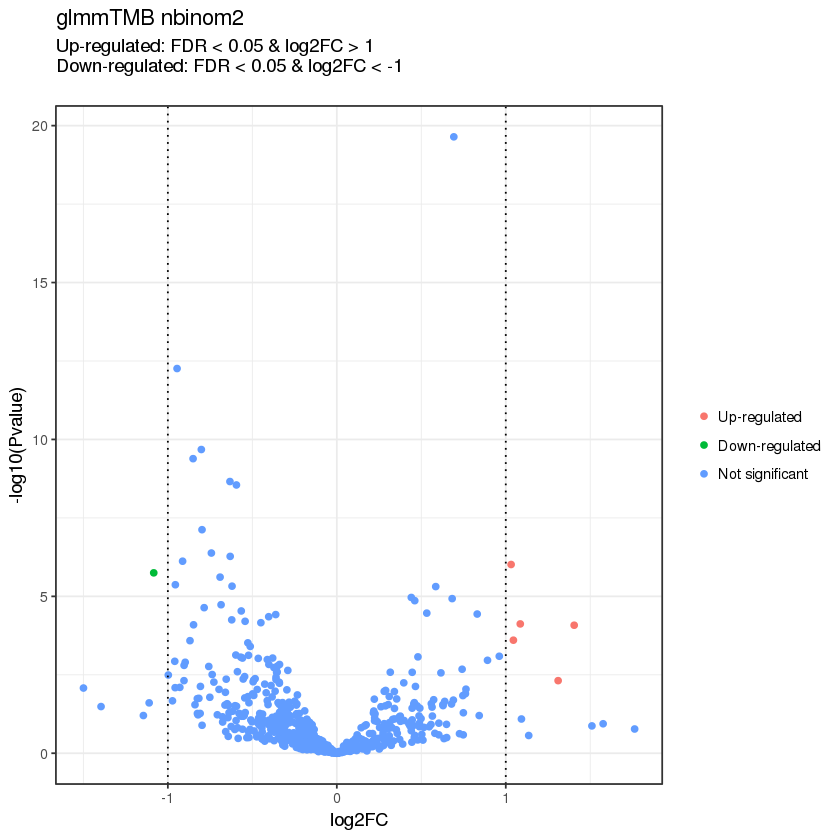

In [25]:
start_time = proc.time()
glmmTMB.res <- sce_qc$glmmTMB_pipeline(covs = covars, family = "nbinom2", detection_rate = FALSE,cores=8)
head(glmmTMB.res)
sce_qc$volcanoPlot(FDR_threshold = 0.05, FC_threshold = 2, title = "glmmTMB nbinom2")
print(proc.time()-start_time)

Joining, by = "cell"


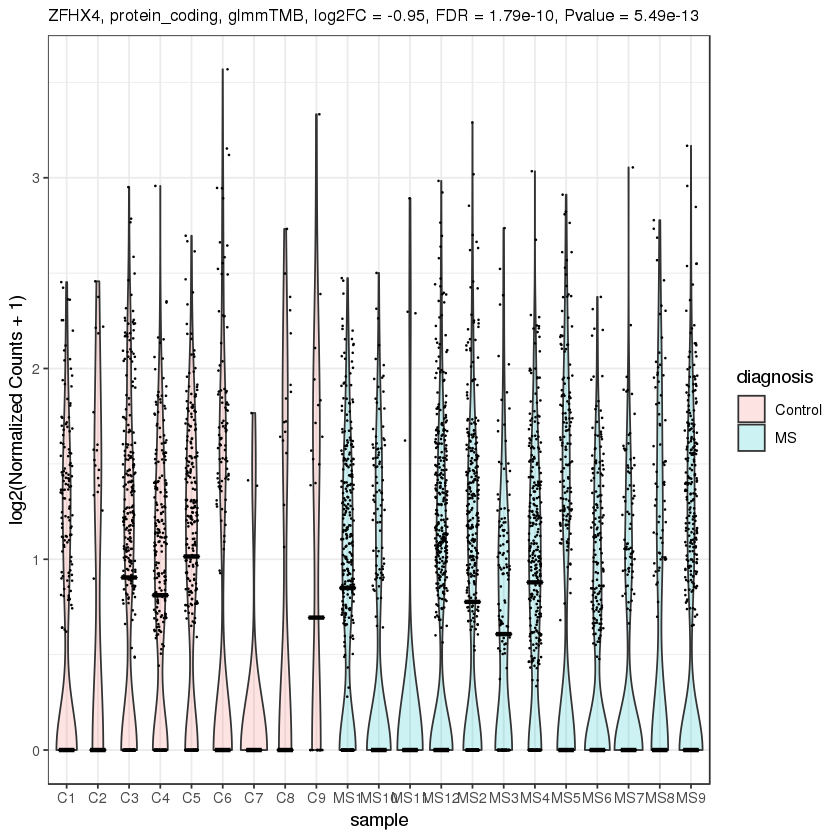

In [26]:
sce_qc$violinPlot(gene.name="ZFHX4",de.method="glmmTMB",cellinfo="cell")